In [1]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import LearningRateScheduler

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 类别数
num_classes = 17
# 批次大小
batch_size = 32
# 周期数
epochs = 100
# 图片大小
image_size = 224

In [3]:
# 训练集数据进行数据增强
train_datagen = ImageDataGenerator(
    rotation_range = 20,     # 随机旋转度数
    width_shift_range = 0.1, # 随机水平平移
    height_shift_range = 0.1,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 10,       # 随机错切变换
    zoom_range = 0.1,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    brightness_range=(0.7, 1.3), # 亮度变化
    fill_mode = 'nearest',   # 填充方式
) 
# 测试集数据只需要归一化就可以
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
) 

In [4]:
# 训练集数据生成器，可以在训练时自动产生数据进行训练
# 从'data/train'获得训练集数据
# 获得数据后会把图片resize为image_size×image_size的大小
# generator每次会产生batch_size个数据
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

# 测试集数据生成器
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(image_size,image_size),
    batch_size=batch_size,
    )

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [5]:
# 字典的键为17个文件夹的名字，值为对应的分类编号
train_generator.class_indices

{'flower0': 0,
 'flower1': 1,
 'flower10': 2,
 'flower11': 3,
 'flower12': 4,
 'flower13': 5,
 'flower14': 6,
 'flower15': 7,
 'flower16': 8,
 'flower2': 9,
 'flower3': 10,
 'flower4': 11,
 'flower5': 12,
 'flower6': 13,
 'flower7': 14,
 'flower8': 15,
 'flower9': 16}

In [6]:
# AlexNet
model = Sequential()
# 卷积层
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding='valid',input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2),padding='valid'))
# 全连接层
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# 模型概要
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       8

In [7]:
# 学习率调节函数，逐渐减小学习率
def adjust_learning_rate(epoch):
    # 前30周期
    if epoch<=30:
        lr = 1e-4
    # 前30到70周期
    elif epoch>30 and epoch<=70:
        lr = 1e-5
    # 70到100周期
    else:
        lr = 1e-6
    return lr

In [8]:
# 定义优化器
adam = Adam(lr=1e-4)

# 定义学习率衰减策略
callbacks = []
callbacks.append(LearningRateScheduler(adjust_learning_rate))

# 定义优化器，loss function，训练过程中计算准确率
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

# Tensorflow2.1版本之前可以使用fit_generator训练模型
# history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=epochs,validation_data=test_generator,validation_steps=len(test_generator))

# Tensorflow2.1版本(包括2.1)之后可以直接使用fit训练模型
history = model.fit(x=train_generator,epochs=epochs,validation_data=test_generator,callbacks=callbacks)

W0316 17:00:38.896235  7204 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0316 17:00:39.033895  7204 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 34 steps, validate for 9 steps
Epoch 1/100
34/34 [==============================] - 14s 418ms/step - loss: 2.7750 - accuracy: 0.0800 - val_loss: 2.4774 - val_accuracy: 0.1250
Epoch 2/100
34/34 [==============================] - 13s 395ms/step - loss: 2.4628 - accuracy: 0.1296 - val_loss: 2.2861 - val_accuracy: 0.1949
Epoch 3/100
34/34 [==============================] - 13s 389ms/step - loss: 2.3726 - accuracy: 0.1645 - val_loss: 2.1687 - val_accuracy: 0.1912
Epoch 4/100
34/34 [==============================] - 13s 386ms/step - loss: 2.1378 - accuracy: 0.2279 - val_loss: 2.0564 - val_accuracy: 0.2610
Epoch 5/100
34/34 [==============================] - 13s 387ms/step - loss: 2.0225 - accuracy: 0.2583 - val_loss: 1.9218 - val_accuracy: 0.2610
Epoch 6/100
34/34 [==============================] - 13s 391ms/step - loss: 1.9194 - accuracy: 0.3051 - val_loss: 1.7893 - val_accuracy: 0.3088
Epoch 7/100
34/34 [==============================] - 13s 386ms/step - loss: 1.7793 - accuracy: 

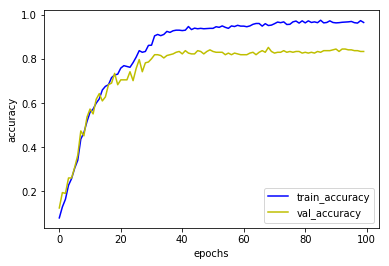

In [9]:
# 画出训练集准确率曲线图
plt.plot(np.arange(epochs),history.history['accuracy'],c='b',label='train_accuracy')
# 画出验证集准确率曲线图
plt.plot(np.arange(epochs),history.history['val_accuracy'],c='y',label='val_accuracy')
# 图例
plt.legend()
# x坐标描述
plt.xlabel('epochs')
# y坐标描述
plt.ylabel('accuracy')
# 显示图像
plt.show()
# 模型保存
model.save('AlexNet.h5')